In [27]:
.libPaths('/root/miniconda3/envs/Rdoc/lib/R/library')

In [28]:
library(scran)

In [29]:
library(SpatialExperiment)

In [30]:
T = readRDS('./Mye.rds')

In [31]:
assay(T, "exprs") <- asinh(counts(T)/1)

In [32]:
biggene = c('FAP','Vimentin','HLA-DR','CD3','CD4','CD8a',
           'CD20')

In [33]:
allgene = rownames(T)

In [34]:
biggene

[1] "FAP"      "Vimentin" "HLA-DR"   "CD3"      "CD4"      "CD8a"     "CD20"

In [35]:
funcge = setdiff(allgene,biggene)

In [36]:
library(batchelor)
set.seed(220228)
out <- fastMNN(T, batch = T$sample_id,
               auto.merge = TRUE,
               subset.row = funcge,
               assay.type = "exprs")

# Check that order of cells is the same
stopifnot(all.equal(colnames(T), colnames(out)))

# Transfer the correction results to the main spe object
reducedDim(T, "fastMNN") <- reducedDim(out, "corrected")

Warning message in check_numbers(k = k, nu = nu, nv = nv, limit = min(dim(x)) - :
“more singular values/vectors requested than available”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


In [37]:
merge_info <- metadata(out)$merge.info 
merge_info[,c("left", "right", "batch.size")]

DataFrame with 60 rows and 3 columns
                                       left       right batch.size
                                     <List>      <List>  <numeric>
1                               T005_ROI012 T005_ROI010   0.260941
2                   T005_ROI012,T005_ROI010 T005_ROI009   0.521208
3       T005_ROI012,T005_ROI010,T005_ROI009 T003_ROI001   0.686283
4   T005_ROI012,T005_ROI010,T005_ROI009,... T005_ROI003   0.399041
5   T005_ROI012,T005_ROI010,T005_ROI009,... T005_ROI005   0.705845
...                                     ...         ...        ...
56  T005_ROI012,T005_ROI010,T005_ROI009,... T002_ROI001   0.948208
57  T005_ROI012,T005_ROI010,T005_ROI009,... T002_ROI011   0.934730
58  T005_ROI012,T005_ROI010,T005_ROI009,... T004_ROI001   0.914406
59  T005_ROI012,T005_ROI010,T005_ROI009,... T005_ROI002   0.937718
60  T005_ROI012,T005_ROI010,T005_ROI009,... T004_ROI004   0.937918

In [38]:
spe =T

In [39]:
library(scater)
set.seed(220228)
spe <- runUMAP(T, dimred= "fastMNN", name = "UMAP_mnnCorrected") 

In [40]:
library(Rphenograph)
library(igraph)
library(dittoSeq)

In [41]:
mat <- t(assay(T, "exprs")[funcge,])
set.seed(230619)
# out <- Rphenograph(mat, k = 25)
# clusters <- factor(membership(out[[2]]))
# spe$pg_clusters_corrected <- clusters

In [42]:
# dittoDimPlot(spe, var = "pg_clusters_corrected", 
#              reduction.use = "UMAP_mnnCorrected", size = 0.2,
#              do.label = TRUE) +
#     ggtitle("Phenograph clusters on UMAP, integrated cells")

###  bluster

In [43]:
library(bluster)
library(BiocParallel)
library(ggplot2)

mat <- t(assay(spe, "exprs")[funcge,])

In [44]:
spe

class: SpatialExperiment 
dim: 38 24580 
metadata(0):
assays(2): counts exprs
rownames(38): IL-6 CD14 ... HIF1a Vimentin
rowData names(0):
colnames(24580): T001_ROI001.3 T001_ROI001.4 ... T005_ROI012.3208
  T005_ROI012.3210
colData names(8): AreaID CellID ... patient_id celltype
reducedDimNames(2): fastMNN UMAP_mnnCorrected
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : Pos_X Pos_Y
imgData names(1): sample_id

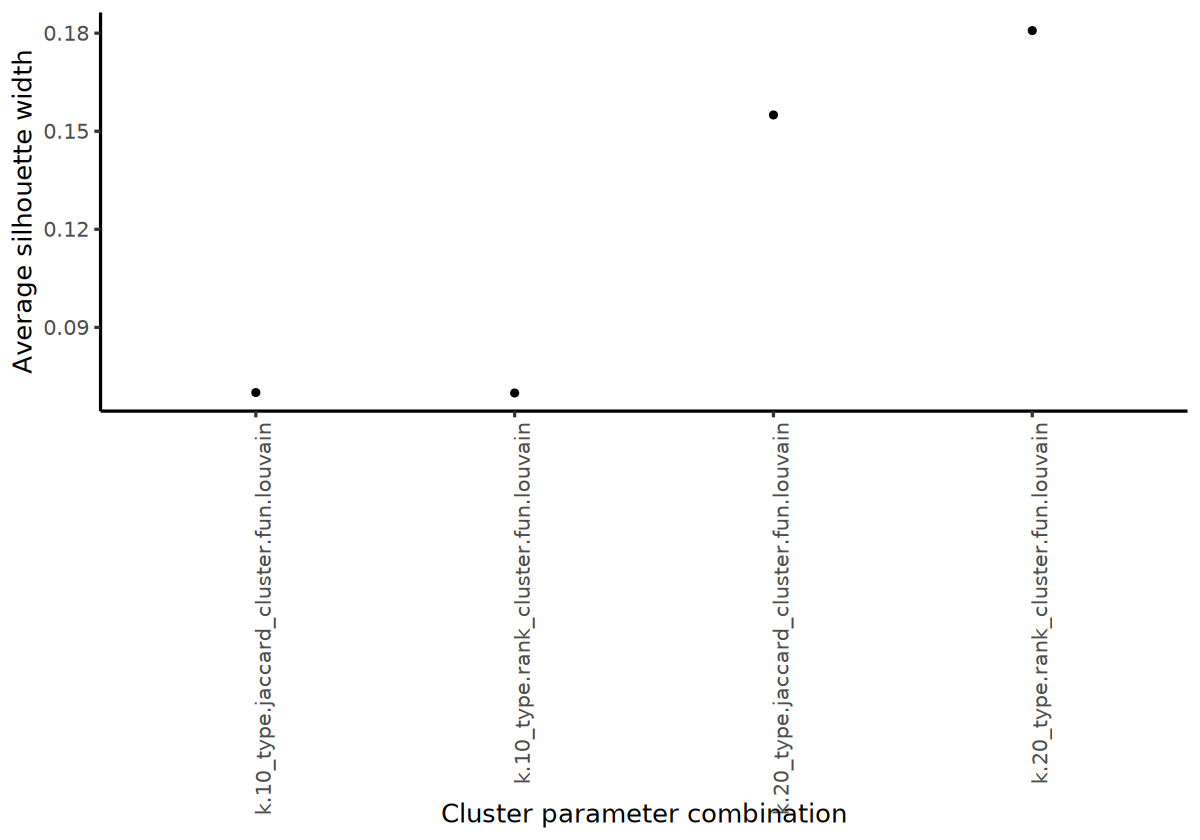

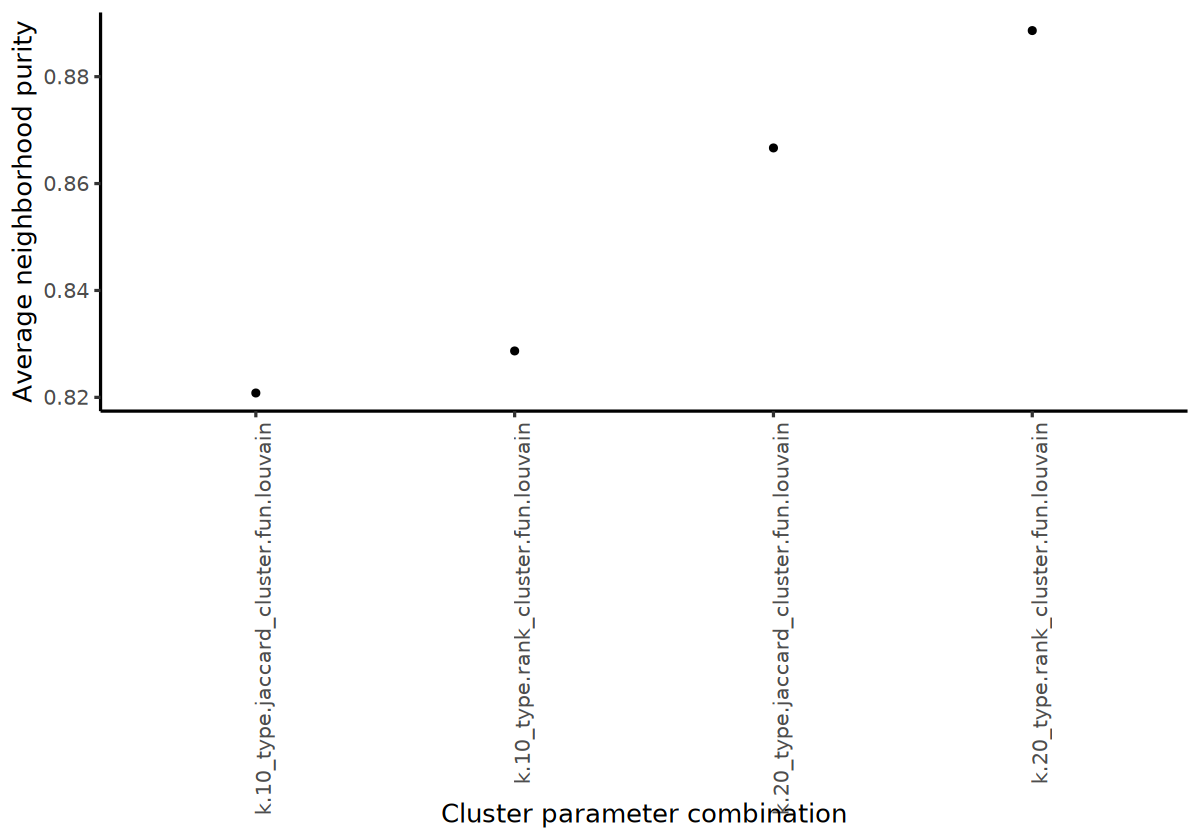

In [45]:
combinations <- clusterSweep(mat, 
                             BLUSPARAM=SNNGraphParam(),
                             k=c(10L, 20L), 
                             type = c("rank", "jaccard"), 
                             cluster.fun = "louvain",
                             BPPARAM = MulticoreParam(RNGseed = 220427))

sil <- vapply(as.list(combinations$clusters), 
              function(x) mean(approxSilhouette(mat, x)$width), 
              0)

ggplot(data.frame(method = names(sil),
                  sil = sil)) +
    geom_point(aes(method, sil)) +
    theme_classic(base_size = 15) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    xlab("Cluster parameter combination") +
    ylab("Average silhouette width")

pur <- vapply(as.list(combinations$clusters), 
              function(x) mean(neighborPurity(mat, x)$purity), 
              0)

ggplot(data.frame(method = names(pur),
                  pur = pur)) +
    geom_point(aes(method, pur)) +
    theme_classic(base_size = 15) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    xlab("Cluster parameter combination") +
    ylab("Average neighborhood purity")

set.seed(220621)
clusters <- clusterCells(spe, 
                         use.dimred = "fastMNN", 
                         BLUSPARAM = SNNGraphParam(k = 20, 
                                        cluster.fun = "louvain",
                                        type = "rank"))

spe$nn_clusters_corrected <- clusters

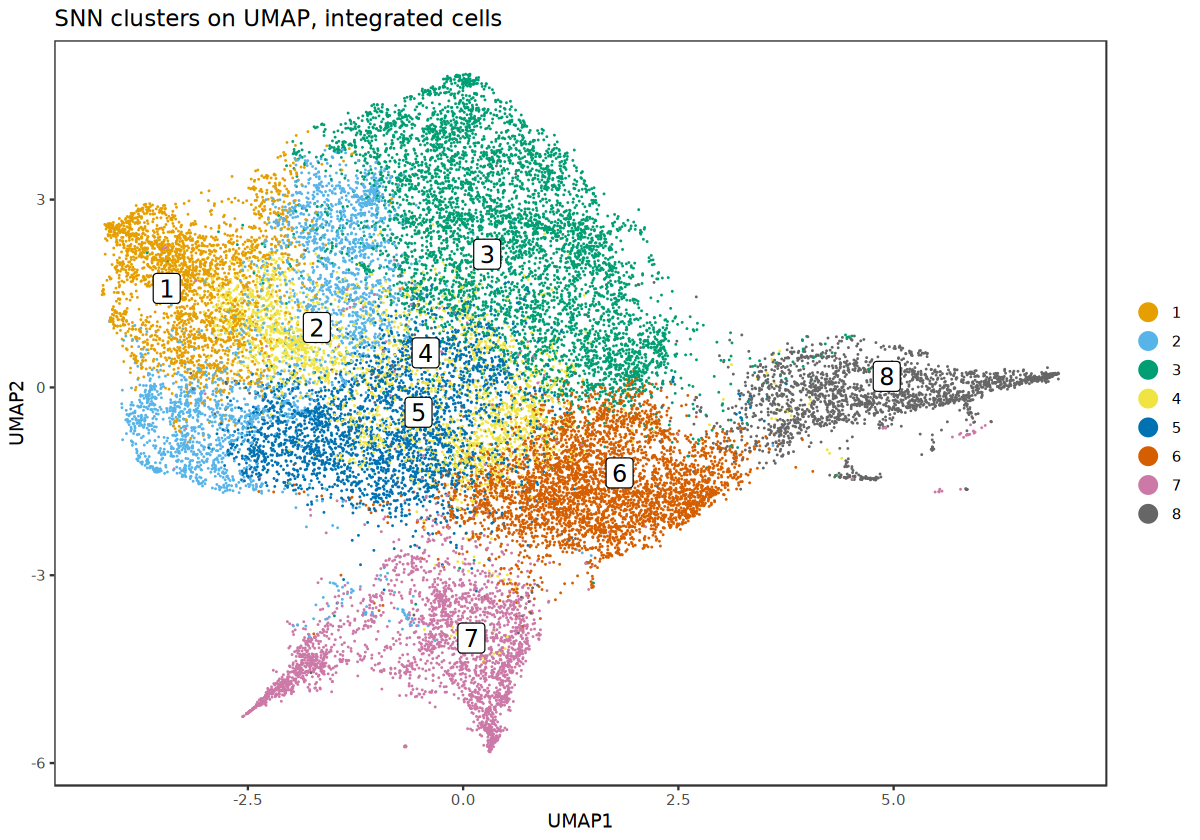

In [46]:
dittoDimPlot(spe, var = "nn_clusters_corrected", 
             reduction.use = "UMAP_mnnCorrected", size = 0.2,
             do.label = TRUE) +
    ggtitle("SNN clusters on UMAP, integrated cells")

In [47]:
library(stringr)

In [48]:
spe$ROI <- str_sub(spe$sample_id, -3, -1)
spe$patient_id <- str_extract(spe$sample_id, "T00[1-5]")

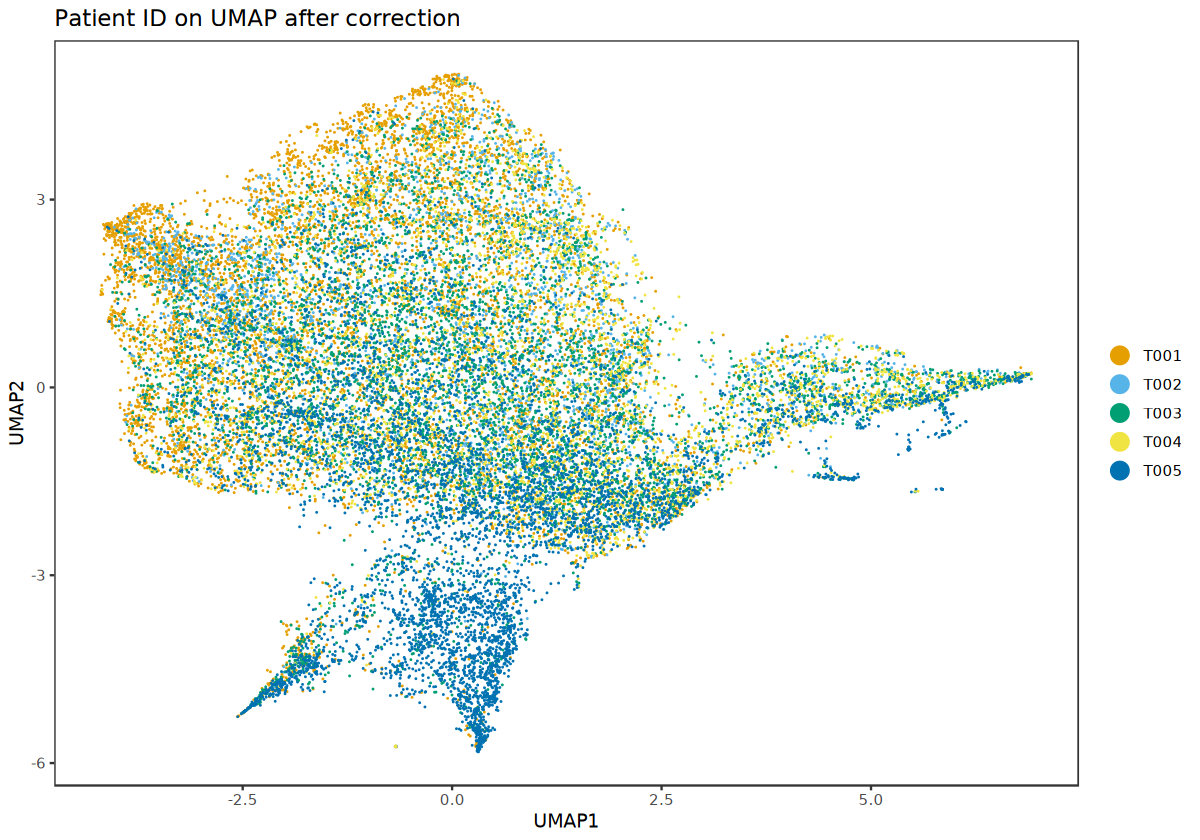

In [49]:
library(cowplot)
library(dittoSeq)
library(viridis)
dittoDimPlot(spe, var = "patient_id", 
                   reduction.use = "UMAP_mnnCorrected", size = 0.2) + 
   #scale_color_manual(values = metadata(spe)$color_vectors$patient_id) +
    ggtitle("Patient ID on UMAP after correction")

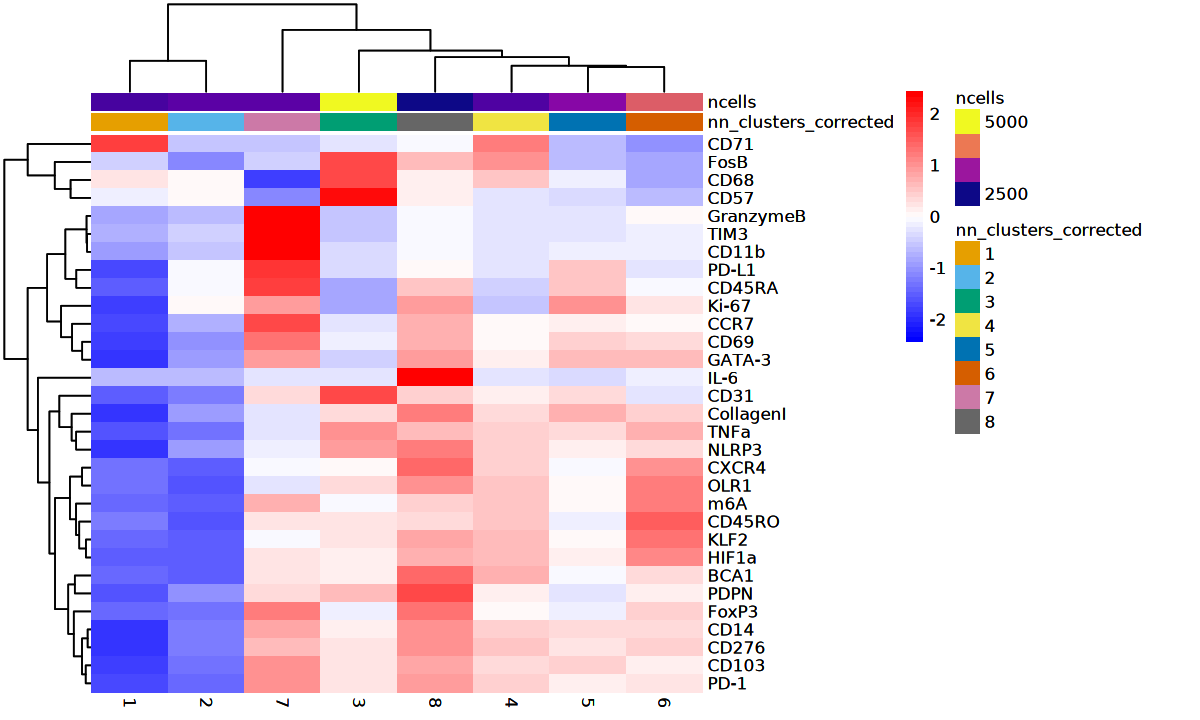

In [78]:
library(scuttle)

## aggregate by cell type
celltype_mean <- aggregateAcrossCells(as(spe, "SingleCellExperiment"),  
                     ids = spe$nn_clusters_corrected, 
                     statistics = "mean",
                     use.assay.type = "exprs", 
                     subset.row =c(funcge) )

library(dittoSeq)
library(colorspace)
library(viridis)

options(repr.plot.width = 10)

dittoHeatmap(celltype_mean,
             assay = "exprs", 
             cluster_cols = TRUE, show_rownames = TRUE,show_colnames =TRUE,
             annot.by = c("nn_clusters_corrected", "ncells"),
             annotation_colors = list(celltype = metadata(spe)$color_vectors$nn_clusters_corrected,
                                      ncells = plasma(100)))

### 细胞注释

In [79]:
library(dplyr)
cluster_celltype <- recode(spe$nn_clusters_corrected,
                            '1' = 'Mye_CD71',
                           '2' = 'unlabel',
                           '7' = 'unlabel',
                           '3' = 'Mye_CD57_FosB',
                           '8' = 'Mye_IL6',
                            '4' = 'Mye_CD71',
                           '5' = 'unlabel',
                           '6' = 'Mye_KLF2_HIF1a'                                 
)

In [80]:
spe$celltype <- cluster_celltype

In [81]:
label = unique(spe$celltype)[-2]

In [82]:
label

[1] Mye_CD71       Mye_CD57_FosB  Mye_KLF2_HIF1a Mye_IL6       
Levels: Mye_CD71 unlabel Mye_CD57_FosB Mye_KLF2_HIF1a Mye_IL6

In [83]:
mye = spe[,spe$celltype %in% c(label)]

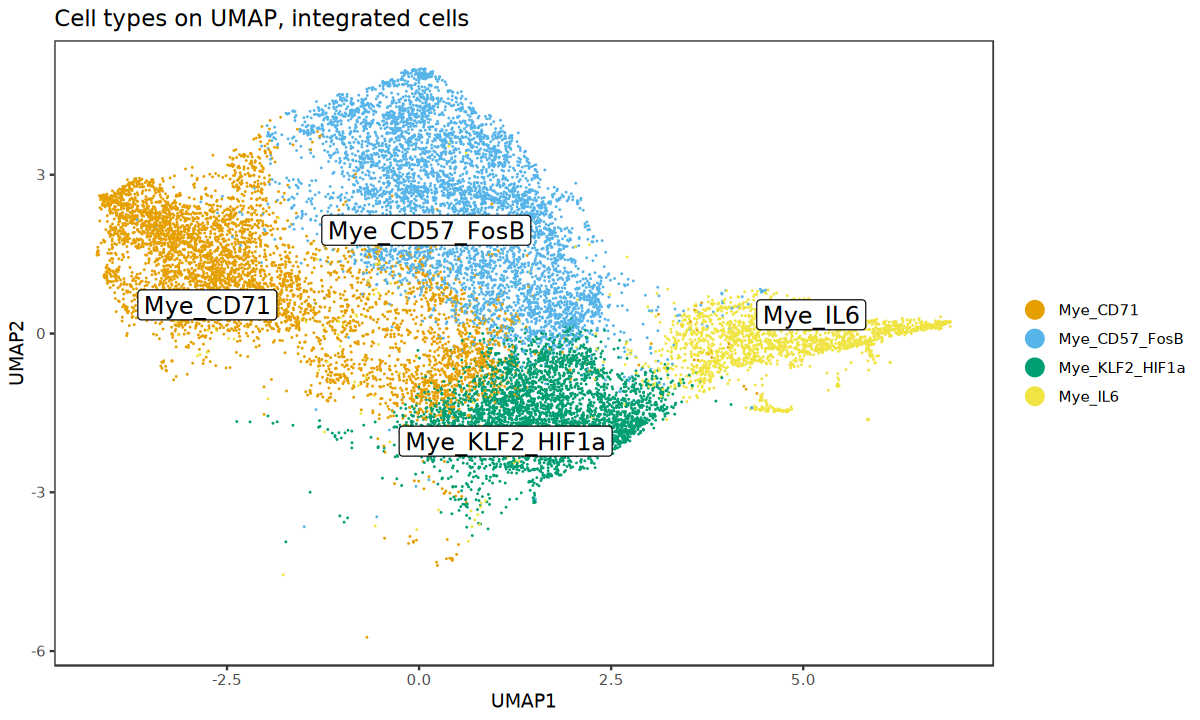

In [84]:
dittoDimPlot(mye, 
                   var = "celltype", 
                   reduction.use = "UMAP_mnnCorrected", 
                   size = 0.2,
                   do.label = TRUE) +
 # scale_color_manual(values = metadata(spe)$color_vectors$celltype) +
  theme(legend.title = element_blank()) +
  ggtitle("Cell types on UMAP, integrated cells")

In [61]:
table(mye$celltype, mye$patient_id)

                
                 T001 T002 T003 T004 T005
  Mye_CD71       2116  955  923  426  590
  unlabel           0    0    0    0    0
  Mye_CD57_FosB  1974  900 1186  916  334
  Mye_KLF2_HIF1a  545  358 1031  719 1302
  Mye_TIM3_GRZB   262   39  363   30 1922
  Mye_IL6         180  319  599  534  468

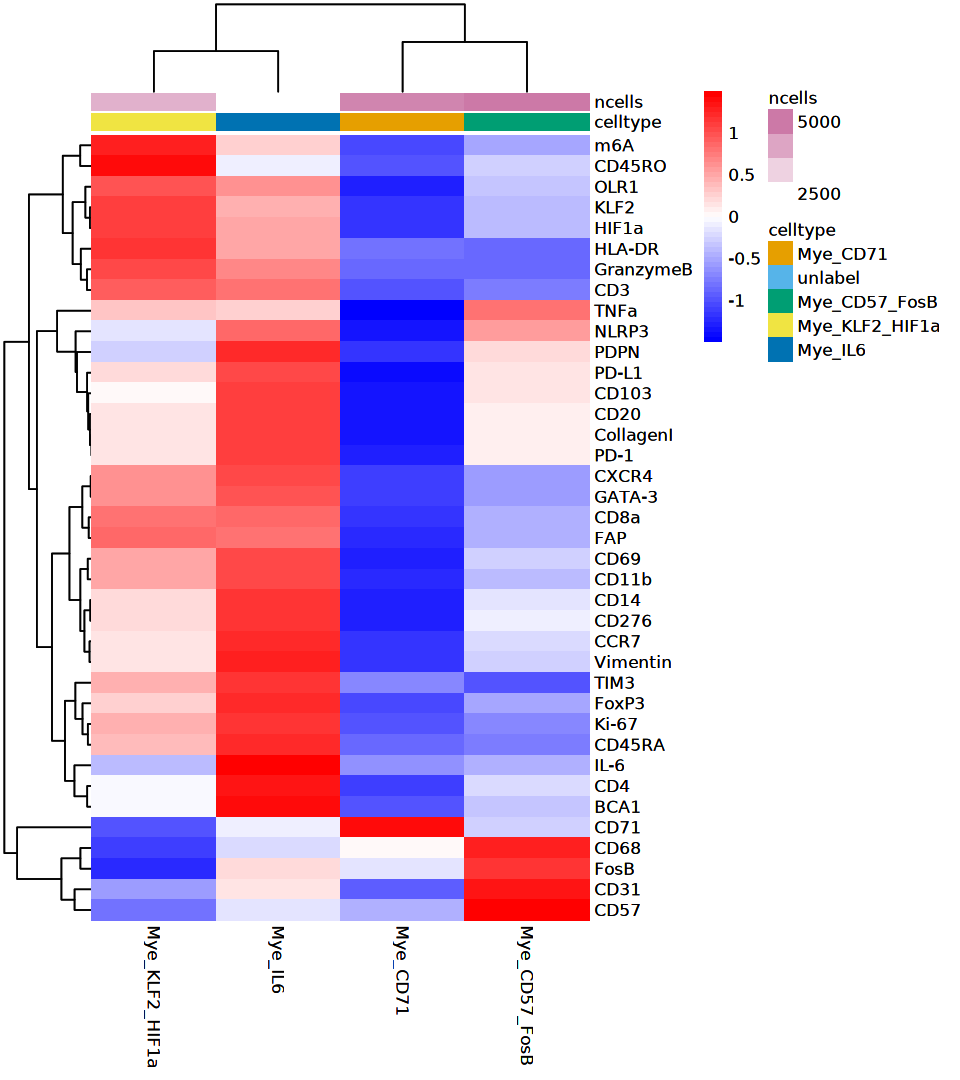

In [85]:
library(scuttle)

## aggregate by cell type
celltype_mean <- aggregateAcrossCells(as(mye, "SingleCellExperiment"),  
                     ids = mye$celltype, 
                     statistics = "mean",
                     use.assay.type = "exprs", 
                     subset.row = rownames(mye))

library(dittoSeq)
library(colorspace)
library(viridis)

options(repr.plot.width = 8,repr.plot.height = 9)

dittoHeatmap(celltype_mean,
             assay = "exprs", 
             cluster_cols = TRUE, show_rownames = TRUE,show_colnames =TRUE,
             annot.by = c("celltype", "ncells"))

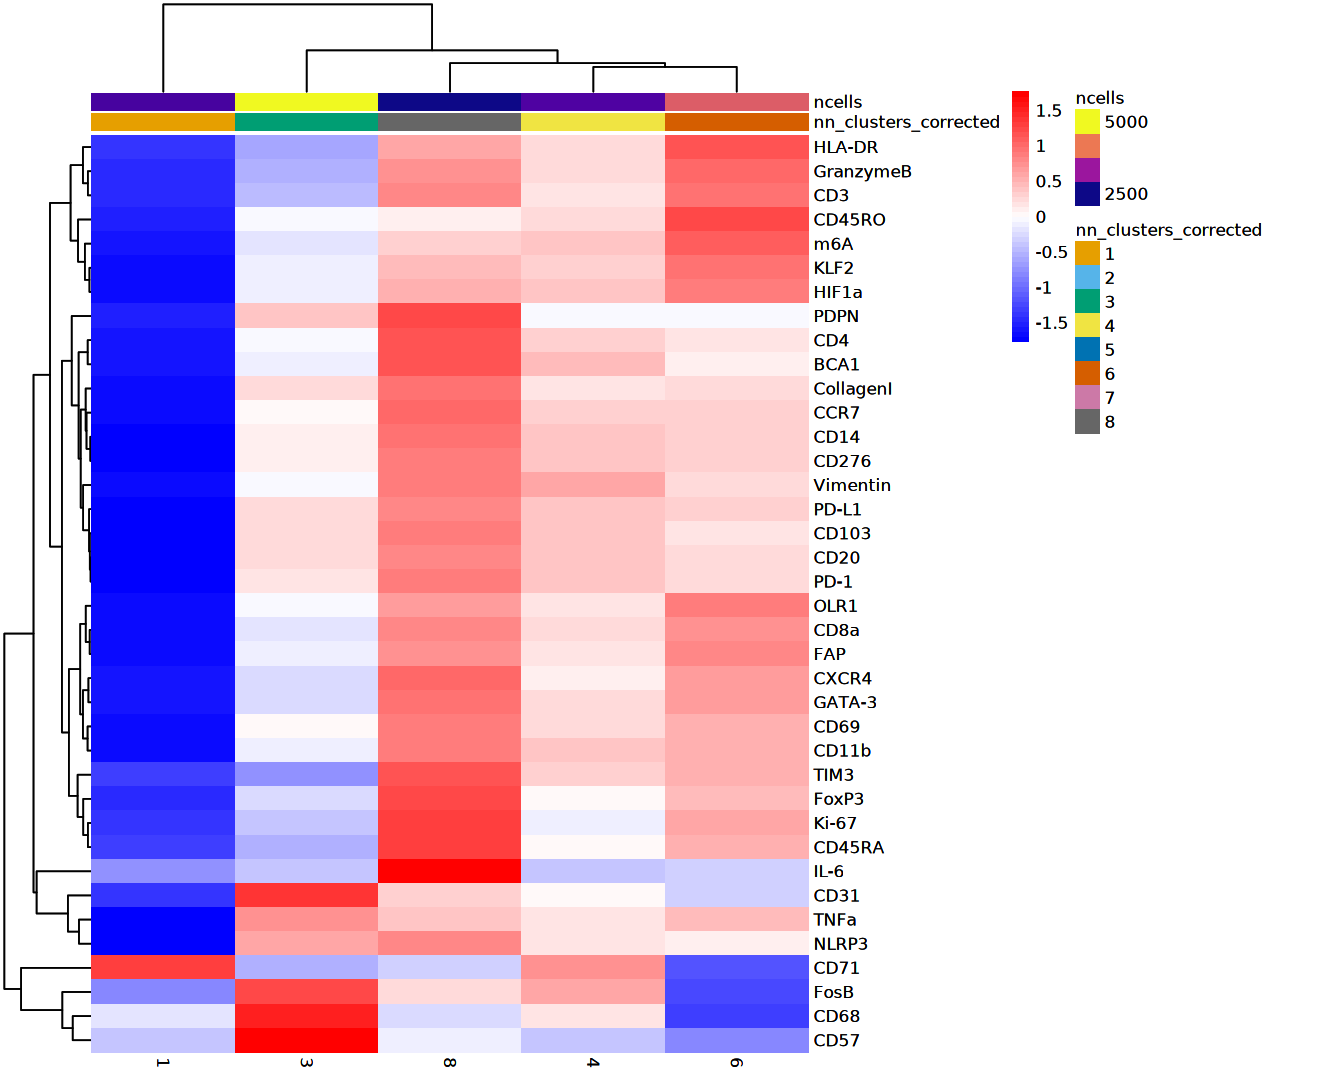

In [86]:
library(scuttle)

## aggregate by cell type
celltype_mean <- aggregateAcrossCells(as(mye, "SingleCellExperiment"),  
                     ids = mye$nn_clusters_corrected, 
                     statistics = "mean",
                     use.assay.type = "exprs", 
                     subset.row = rownames(mye))

library(dittoSeq)
library(colorspace)
library(viridis)

options(repr.plot.width = 11,repr.plot.height = 9)

dittoHeatmap(celltype_mean,
             assay = "exprs", 
             cluster_cols = TRUE, show_rownames = TRUE,show_colnames =TRUE,
             annot.by = c("nn_clusters_corrected", "ncells"),
             annotation_colors = list(celltype = metadata(mye)$color_vectors$nn_clusters_corrected,
                                      ncells = plasma(100)))

In [87]:
set.seed(220818)
cur_cells <- sample(seq_len(ncol(mye)), 4000)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


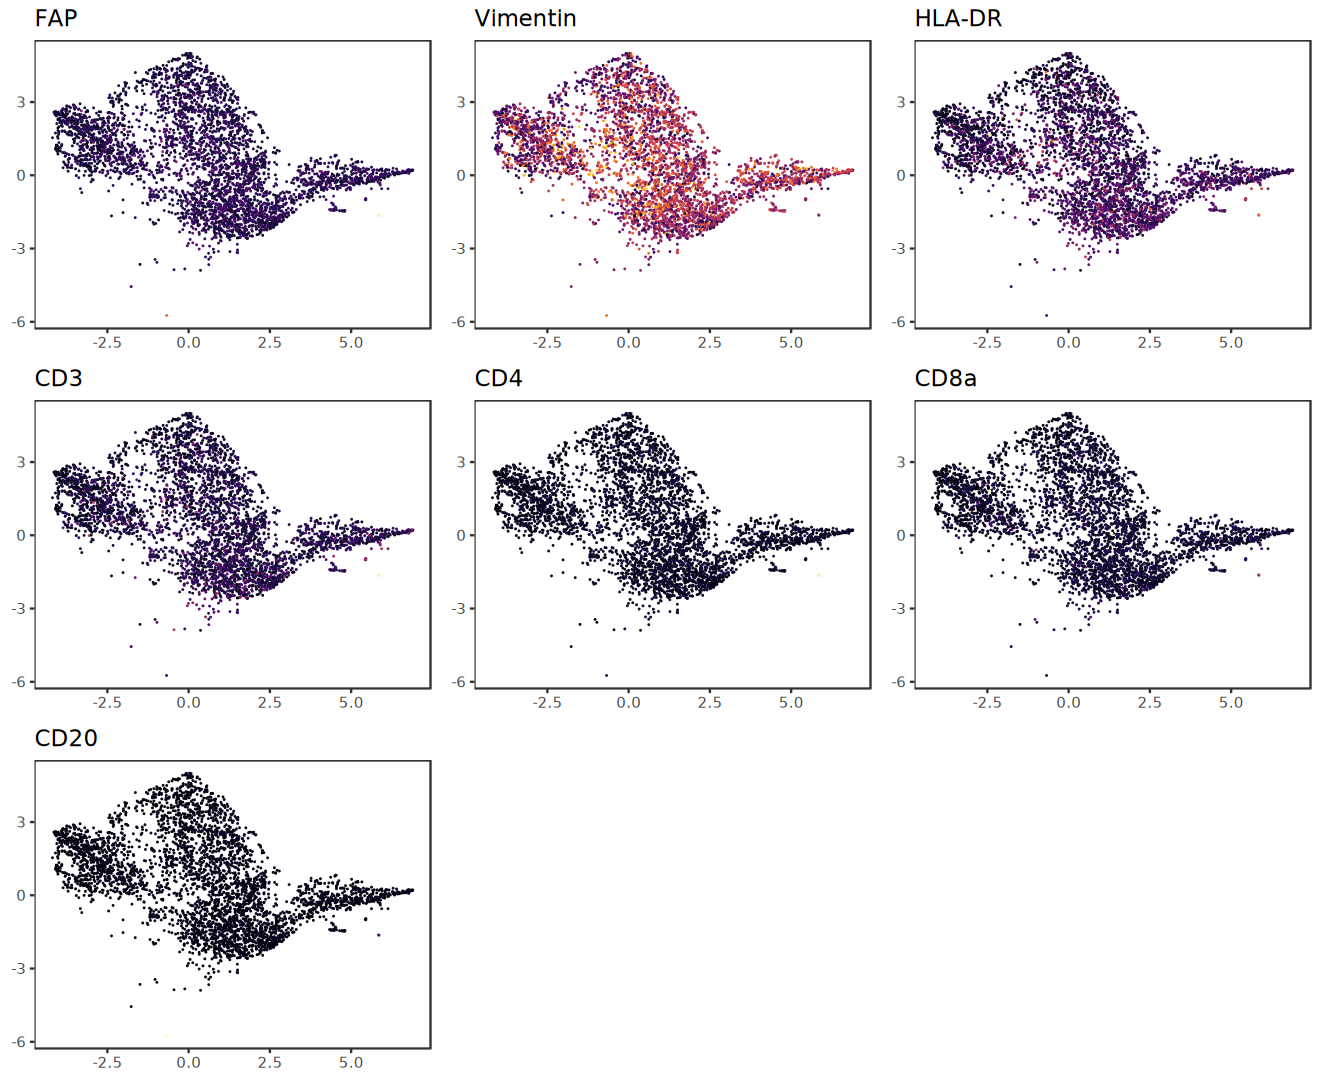

In [88]:
plot_list <- multi_dittoDimPlot(mye[,cur_cells], var = biggene, reduction.use = "UMAP_mnnCorrected", 
                   assay = "exprs", size = 0.2, list.out = TRUE) 
plot_list <- lapply(plot_list, function(x) x + scale_color_viridis(option = "B")  )
plot_grid(plotlist = plot_list) 

In [89]:
library(ggsci)

In [90]:
options(repr.plot.width = 14,repr.plot.height = 9)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


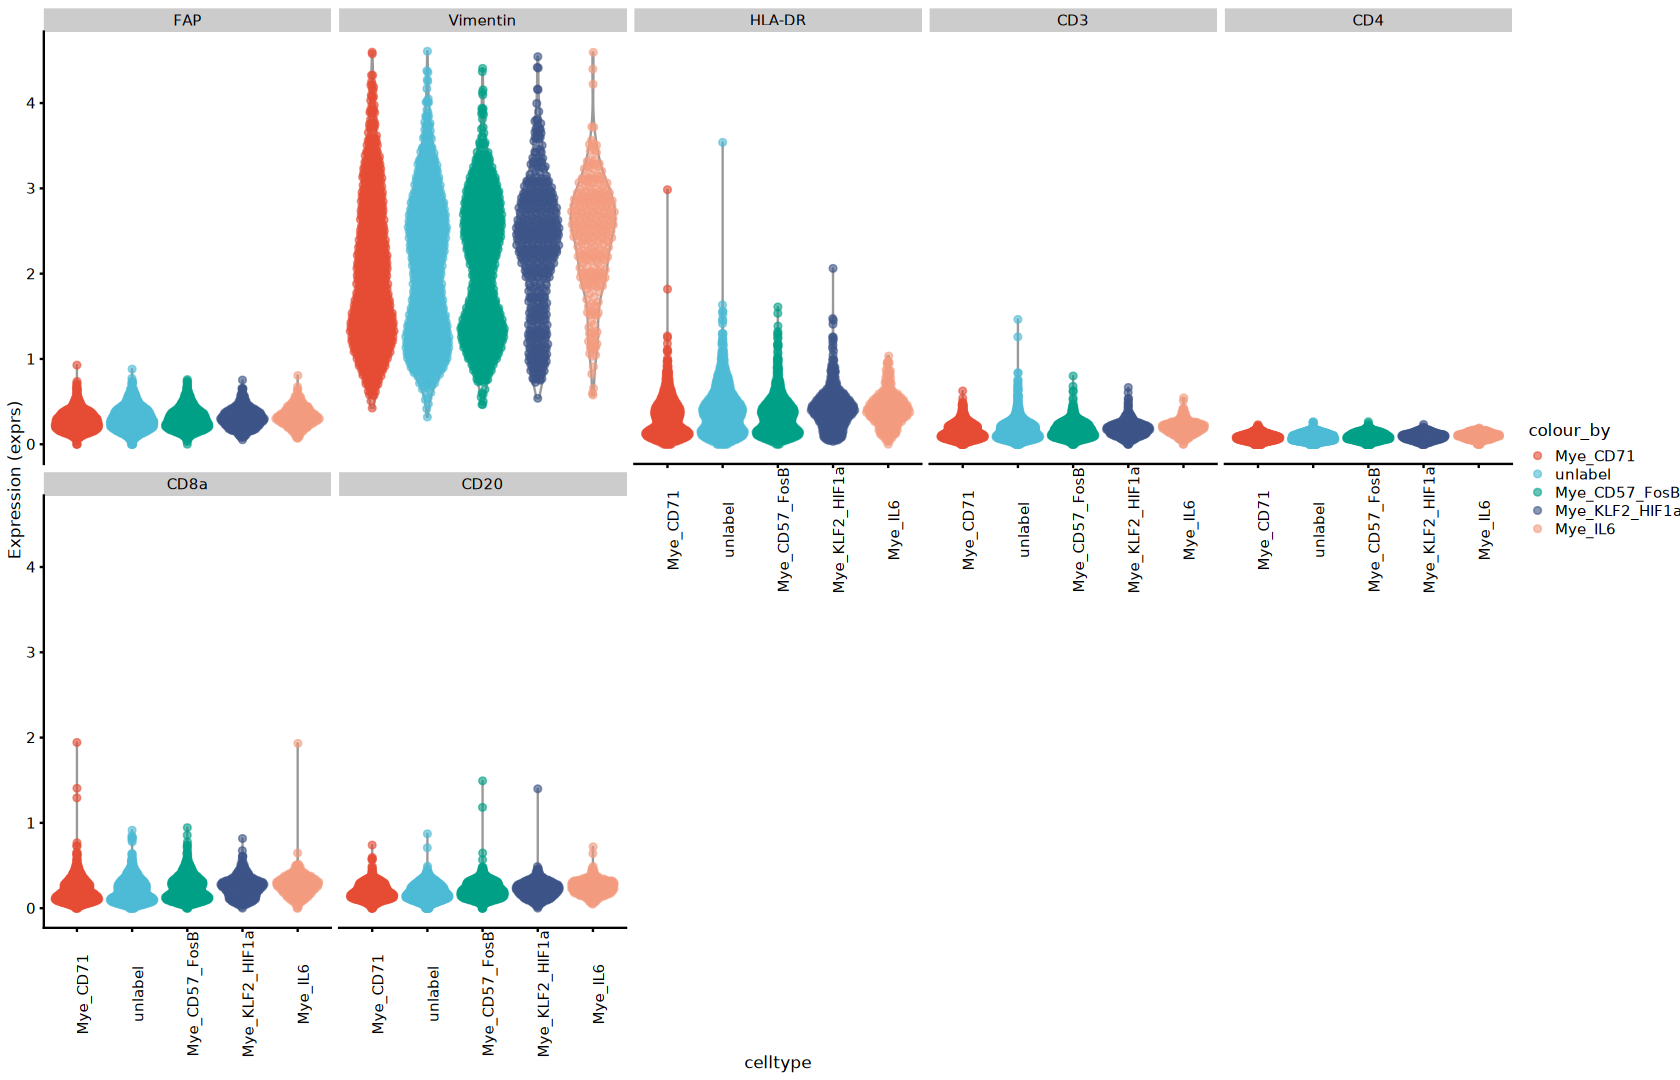

In [91]:
plotExpression(spe[,cur_cells], 
               features = biggene, ncol = 5,
               x = "celltype", 
               exprs_values = "exprs", 
               colour_by = "celltype") +
    theme(axis.text.x =  element_text(angle = 90))+
    scale_color_manual(values = pal_npg("nrc")(10))

In [92]:
options(repr.plot.width = 5,repr.plot.height = 6)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


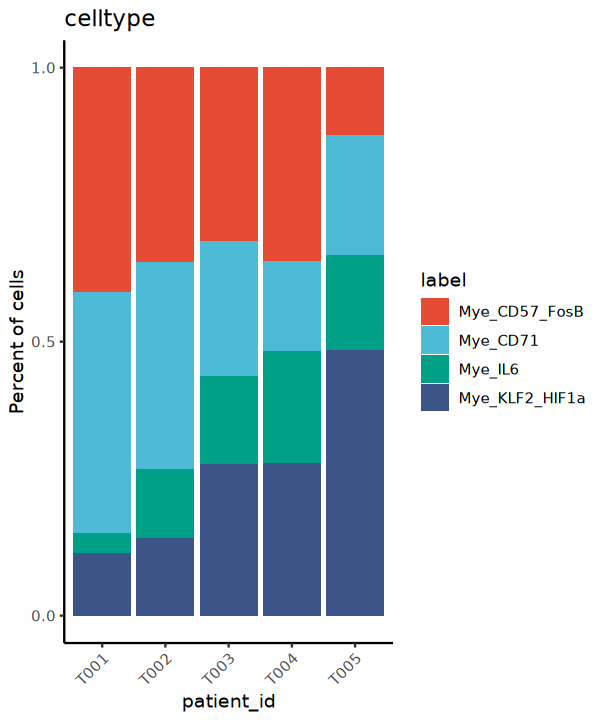

In [93]:
dittoBarPlot(mye, 
             var = "celltype", 
             group.by = "patient_id") +
    scale_fill_manual(values = pal_npg("nrc")(10))

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


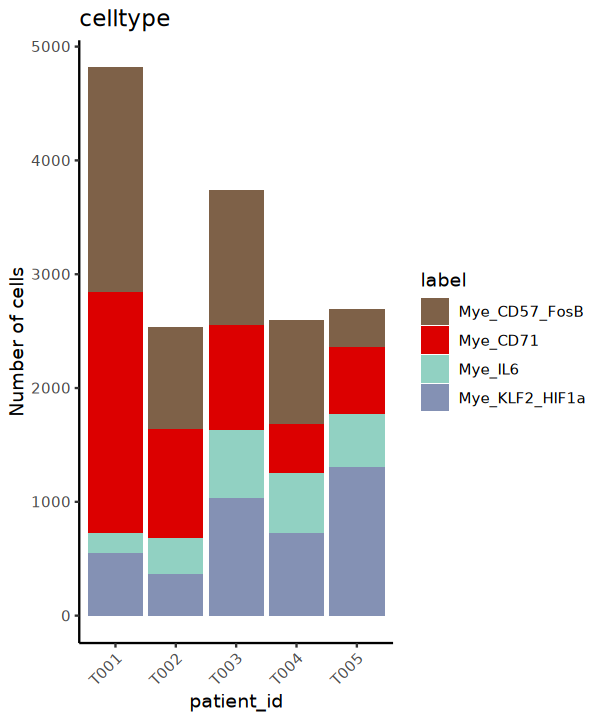

In [96]:
dittoBarPlot(mye, 
             scale = "count",
             var = "celltype", 
             group.by = "patient_id") +
    scale_fill_manual(values = rev(pal_npg("nrc")(9)))

In [95]:
saveRDS(mye,file = 'mye.anno.rds')